# CycleGAN Model 5: Female Portraits with ResNet as Generator

The implementation of CycleGAN so far for the past models uses a U-Net due to it being less computationally expensive. However, the [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) implemented a ResNet with 9 residual blocks. We will replace the U-Net with the  ResNet architecture stated in the paper to see if it improves the generated anime portraits.

**Note**: This notebook was originally run on Google Colab and was reading files from Google Drive, but has been amended to reconcile with the local drive data structure required for github upload. Run cells has been copied from Google Colab such as training cell and pasted into this notebook as proof that the model was trained and showing all the expected output and generated images. This notebook may show Notebook Validation Error when opened locally.

In [1]:
#import the libraries
import tensorflow as tf
from keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Concatenate, Rescaling
from tensorflow.keras.optimizers import Adam
import numpy as np
import os 
import time
import matplotlib.pyplot as plt
import pathlib
!pip install visualkeras
import visualkeras
!pip3 install tensorflow-addons
from tensorflow_addons.layers import InstanceNormalization
AUTOTUNE = tf.data.AUTOTUNE

     |████████████████████████████████| 795 kB 22.5 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 


In [3]:
# size of input image
input_img_size = (256, 256, 3)
img_rows, img_cols, channels = 256, 256, 3

# weights initializer for the layers.
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# define configuration
buffer_size = 256
batch_size = 1
data_path = '../model_and_gen_img/CycleGAN_5/'
epochs = 200

# hyperparameters
LAMBDA = 10 #LAMDBA is restored to 10
LAMBDA_IDENT = 0.5

# set Adam optimizer 
gen_g_optimizer = gen_f_optimizer = Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We will now pre-process the image data

In [4]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1] for 'tanh' activation
    return (img / 127.5) - 1.0

In [5]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_rows, img_cols])

In [6]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [7]:
def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the 256 x 256 first
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

The number of training images is limited to 1216 even though more than 3000 images were available as CycleGAN is computationally very expensive

In [14]:
#Load the Anime train images
data_dir_anime_train = '../data/anime_female_portraits_3400/*'
anime_dir_train = pathlib.Path(data_dir_anime_train)
anime_ds_train = tf.data.Dataset.list_files(str(anime_dir_train), shuffle=True)
anime_ds_train = anime_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
anime_ds_train = anime_ds_train.prefetch(buffer_size=AUTOTUNE)
anime_ds_train = anime_ds_train.take(1216)

In [13]:
#Load the Real Life train images
data_dir_real_train = '../data/real_female_portraits_3318/*'
real_dir_train = pathlib.Path(data_dir_real_train)
real_ds_train = tf.data.Dataset.list_files(str(real_dir_train), shuffle=False)
real_ds_train = real_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
real_ds_train = real_ds_train.prefetch(buffer_size=AUTOTUNE)
real_ds_train = real_ds_train.take(1216)

Create the dataset objects

In [15]:
anime_ds_train = anime_ds_train.cache().map(
    preprocess_train_image, num_parallel_calls=AUTOTUNE).shuffle(
    buffer_size).batch(batch_size)

real_ds_train = real_ds_train.cache().map(
    preprocess_train_image, num_parallel_calls=AUTOTUNE).shuffle(
    buffer_size).batch(batch_size)

## Sample Images

Visualize the sample images

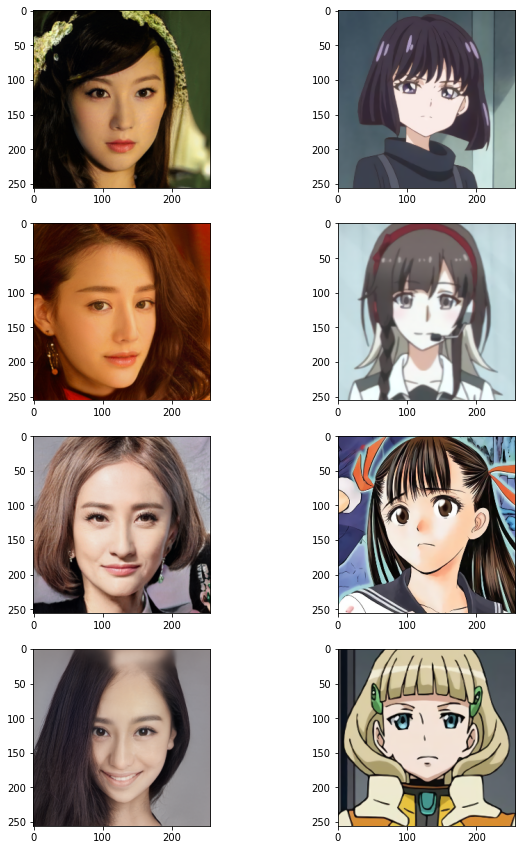

In [16]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(real_ds_train.take(4), anime_ds_train.take(4))):
    real = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    anime = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(real)
    ax[i, 1].imshow(anime)
plt.show();

## Discriminator

The discriminator architecture remain unchanged

In [17]:
# "Ck denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2
def Ck(input, k, use_instancenorm=True):
    block = Conv2D(k, (4, 4), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    if use_instancenorm:
        block = InstanceNormalization(axis=-1)(block)
    block = LeakyReLU(0.2)(block)

    return block

# C64, C128, C256, C512
def discriminator():
    dis_input = Input(shape=(img_rows, img_cols, channels))

    d = Ck(dis_input, 64, False)
    d = Ck(d, 128)
    d = Ck(d, 256)
    d = Ck(d, 512)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=weight_initializer)(d)

    return Model(dis_input, d)

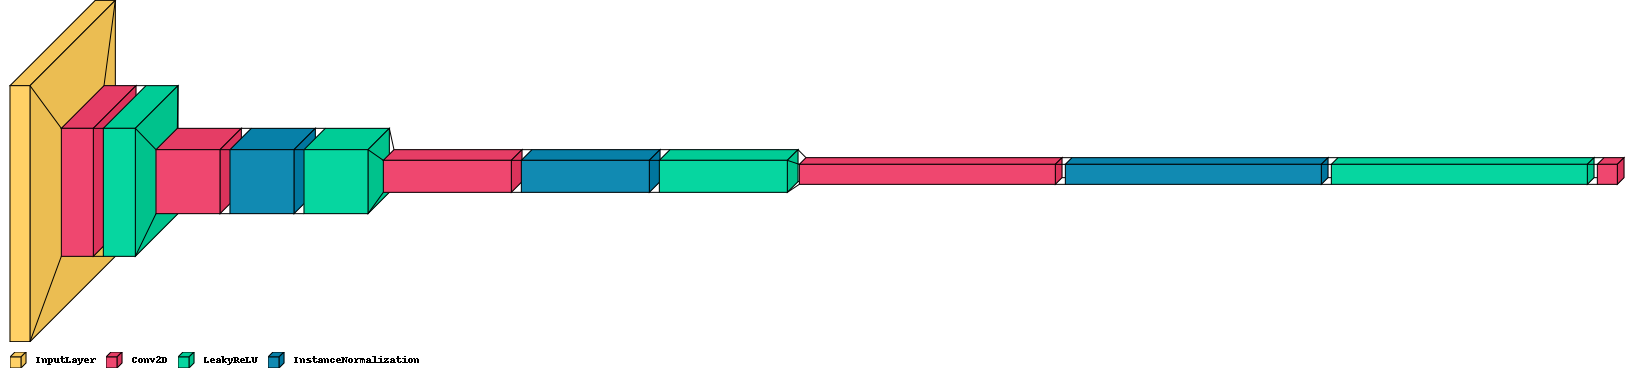

In [18]:
discriminator_cg_rs = discriminator()
visualkeras.layered_view(discriminator_cg_rs, scale_xy = 1, scale_z=0.5, legend=True)

## Generator - Replace U-Net with ResNet

We will however replace the U-Net with ResNet on the generator as implemented in the CycleGAN paper. Code is adapted from [here](https://github.com/EvolvedSquid/tutorials/blob/master/cyclegan/ResNet-generator.py)

In [19]:
img_rows, img_cols, channels = 256, 256, 3
weight_initializer = RandomNormal(stddev=0.02)

# "c7s1-k denotes a 7×7 Convolution-InstanceNorm-ReLU with k filters and stride 1"
def c7s1k(input, k, activation):
    block = Conv2D(k, (7, 7), padding='same', kernel_initializer=weight_initializer)(input)
    block = InstanceNormalization(axis=-1)(block)
    block = Activation(activation)(block)

    return block

# "dk denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def dk(input, k):
    block = Conv2D(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    block = InstanceNormalization(axis=-1)(block)
    block = Activation('relu')(block)

    return block

# "Rk denotes a residual block that contains two 3×3 convolutional layers with k filters on each layer"
def Rk(input, k):
    block = Conv2D(k, (3, 3), padding='same', kernel_initializer=weight_initializer)(input)
    block = InstanceNormalization(axis=-1)(block)
    block = Activation('relu')(block)

    block = Conv2D(k, (3, 3), padding='same', kernel_initializer=weight_initializer)(block)
    block = InstanceNormalization(axis=-1)(block)

    return block + input

# "uk denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½"
def uk(input, k):
    # For the implementation: Conv2DTranspose(..., stride=2) = Conv2D(..., stride=0.5)
    block = Conv2DTranspose(k, (3, 3), strides=2, padding='same', kernel_initializer=weight_initializer)(input)
    block = InstanceNormalization(axis=-1)(block)
    block = Activation('relu')(block)

    return block

# implement 2 layer downsampling block followed by 9 residual blocks and
# 2 layer upsampling block
def generator(res_layers=9):
    gen_input = Input(shape=(img_rows, img_cols, channels))

    gen = c7s1k(gen_input, 64, 'relu')
    gen = dk(gen, 128)
    gen = dk(gen, 256)

    for _ in range(res_layers):
        gen = Rk(gen, 256)

    gen = uk(gen, 128)
    gen = uk(gen, 64)

    gen = c7s1k(gen, 3, 'tanh')

    return Model(gen_input, gen)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_3 (Insta (None, 256, 256, 64) 128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_3[0][0]   
____________________________________________________________________________________________

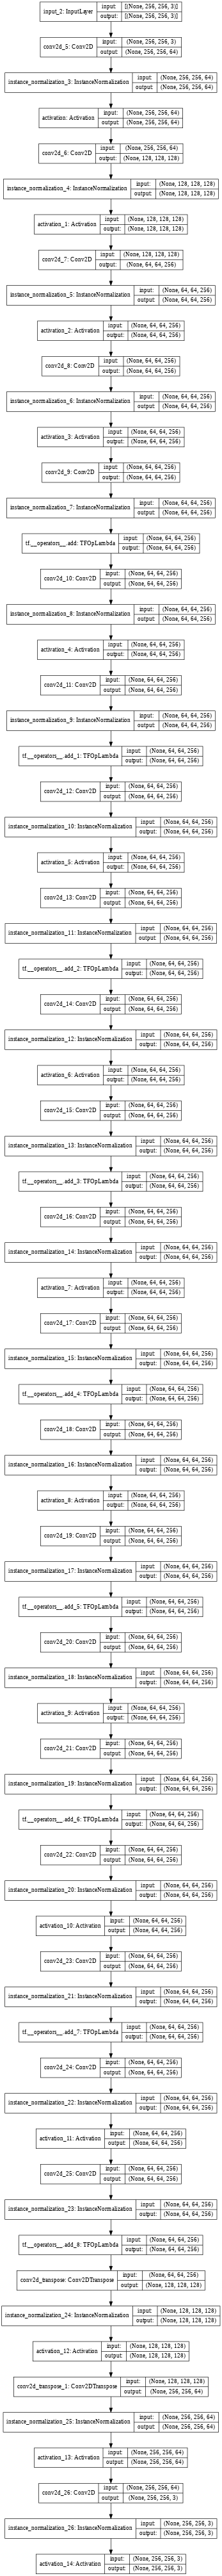

In [21]:
# visualize the generator architecture
generator_cg_rs = generator()
generator_cg_rs.summary()
tf.keras.utils.plot_model(generator_cg_rs, show_shapes=True, dpi=48)

Instantiate the generators and discriminators of the CycleGAN

In [22]:
generator_g = generator() # generates anime images from real-life input images
generator_f = generator() # generates real-life images from anime input images


discriminator_x = discriminator() # takes in real-life and generated real-life images and 
                                  # output probability it is real-life
discriminator_y = discriminator() # takes in anime and generated anime images and 
                                  # output probability it is anime

## Loss Function

Define the loss function

In [23]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [24]:
@tf.function
def step(real_x, real_y):  #real_x : anime, real_y : real-life 
    with tf.GradientTape(persistent=True) as tape:
        # setup Dy loss - how well Discriminator y classify true and generated anime images
        fake_y = generator_g(real_x, training=True) # fake_y : fake anime
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # setup Dx loss - how well Discriminator x classify true and generated real-life images
        fake_x = generator_f(real_y, training=True) # fake_x : fake real-life
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

       # calculate gradient and update weights of discriminators
        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity) # how well generator_g outputs anime which discriminator_y 
                                                  # thinks is real anime
        gen_f_adv_loss = gen_loss(gen_f_validity) # how well generator_f outputs real-life images which
                                                  # discriminator_y thinks is real-life

        # setup cycle losses
        cyc_x = generator_f(fake_y, training=True) 
        cyc_x_loss = image_similarity(real_x, cyc_x) # similarity between real-life image and generated real-life
                                                     # image from one cycle through generator_g followed by generator_f

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y) # similarity between anime image and generated anime image
                                                      # from one cycle through generator_f followed by generator_g
        
        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x) # similarity between real-life image and generated real-life image
                                                   # through inputting real-life image into generator_f

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y) # similarity between anime image and generated anime image
                                                   # through inputting anime image into generator_g

        # Finalize generator losses and calc gradients
        # LAMBDA scales cyclic losses importance w.r.t. adversarial losses
        # LAMBDA_IDENT scales identity losses importance further w.r.t. adversarial losses
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * LAMBDA_IDENT*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * LAMBDA_IDENT*LAMBDA

        # calculate gradient and update weights of generators
        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

Define a function for generating and saving a random anime images at each epoch

In [25]:
def generate_images():
    # Sample images
    real = next(iter(real_ds_train.shuffle(1000))).numpy()
    
    # Get predictions for those images
    anime_hat = generator_g.predict(real.reshape((1, img_rows, img_cols, channels)))
    
    plt.figure(figsize=(15, 7.5))

    images = [real[0], anime_hat[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    # plt.tight_layout()

    output_path = os.path.join(data_path,'generated_images')
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{epoch}.png")
    plt.savefig(filename)
    plt.show()

Construct a Checkpoint object

In [26]:
checkpoint_path = data_path +'training_checkpoints'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           gen_g_optimizer=gen_g_optimizer,
                           gen_f_optimizer=gen_f_optimizer,
                           dis_x_optimizer=dis_x_optimizer,
                           dis_y_optimizer=dis_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


Train the model for 200 epochs. The cell was keyboard interrupted at epoch no. 58.

In [ ]:
# Manually loop through epochs
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((real_ds_train, anime_ds_train))):
        if k % 100 == 0: print(k)
        # Train step
        step(tf.reshape(real_x, (1, img_rows, img_cols, channels)), tf.reshape(real_y, (1, img_rows, img_cols, channels)))
    
    # View progress
    generate_images()

    # Save the model every 10 epochs
    if (epoch + 1) % 20 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, 
                                                           ckpt_save_path))
    print('Time taken: {}'.format(time.time() - start))

## Generate Anime from Test Images

Generate Anime Samples from Test Real-Life Images

In [27]:
real_test_paths = ['../data/real_female_portraits_11/v3_0081950.jpg',
                   '../data/real_female_portraits_11/v3_0106693.jpg',
                   '../data/real_female_portraits_11/v3_0342258.jpg',
                   '../data/real_female_portraits_11/v3_0458352.jpg',
                   '../data/real_female_portraits_11/v3_0486690.jpg',
                   '../data/real_female_portraits_11/v3_0489297.jpg',
                   '../data/real_female_portraits_11/v3_0666509.jpg',
                   '../data/real_female_portraits_11/v3_0684698.jpg',
                   '../data/real_female_portraits_11/v3_0749738.jpg',
                   '../data/real_female_portraits_11/v3_0784113.jpg',
                   '../data/real_female_portraits_11/v3_0930467.jpg']

def gen_test_image(test_image_path):
  real_test_image = tf.keras.preprocessing.image.load_img(test_image_path)
  input_arr_test = tf.keras.preprocessing.image.img_to_array(real_test_image)
  input_arr_test = np.array([input_arr_test])
  input_arr_test = preprocess_train_image(input_arr_test)
  input_arr_test = input_arr_test.numpy()
  plt.figure(figsize=(10, 5))
  predictions = generator_g.predict(input_arr_test.reshape((1, img_rows, img_cols, channels)))
  images = [input_arr_test[0], predictions[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(images[i] * 0.5 + 0.5)
      plt.axis('off')
  # plt.tight_layout()
  plt.show()

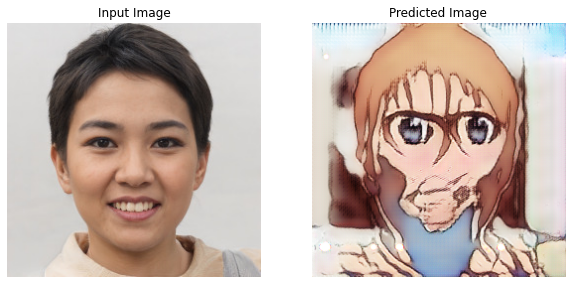

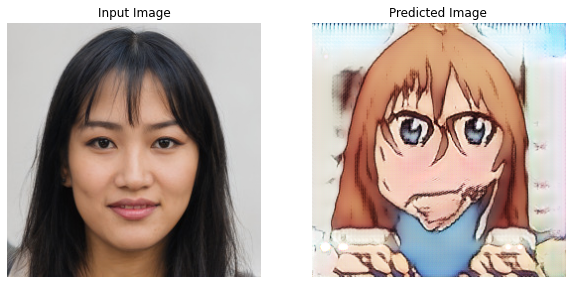

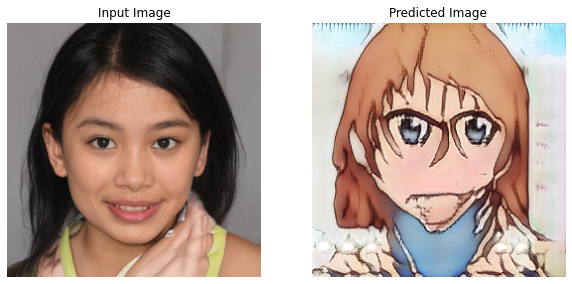

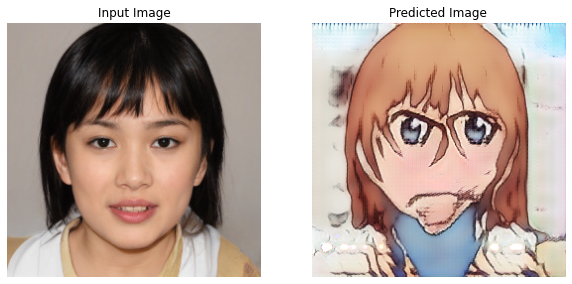

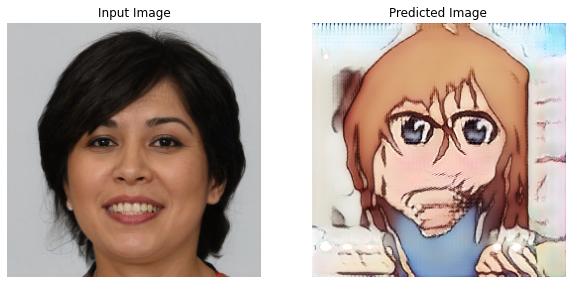

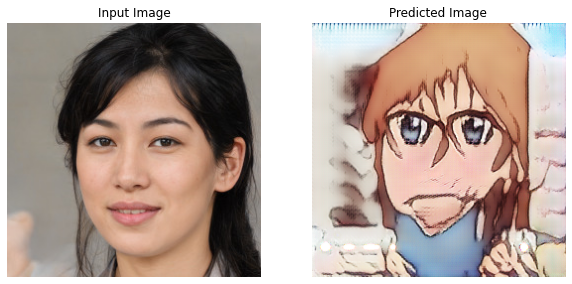

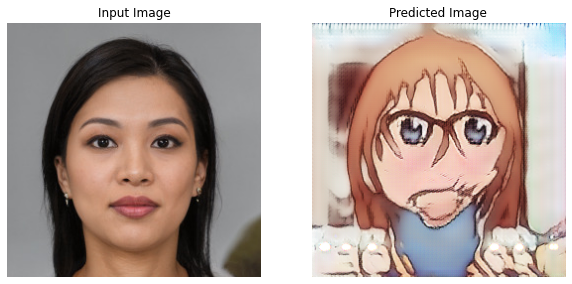

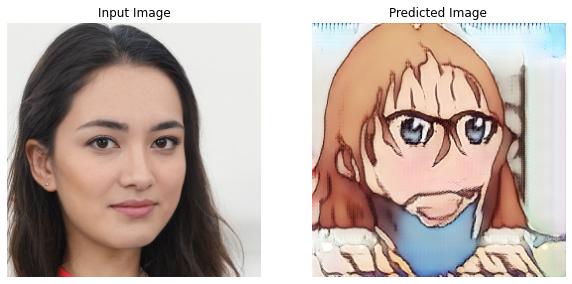

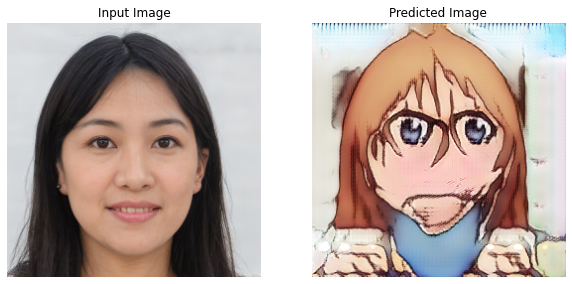

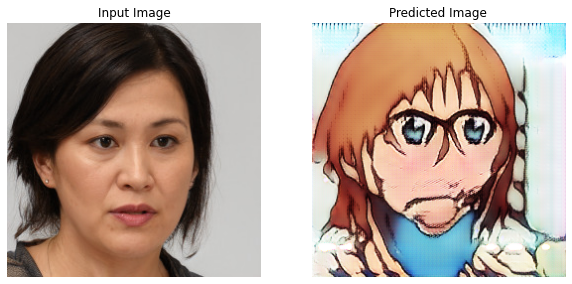

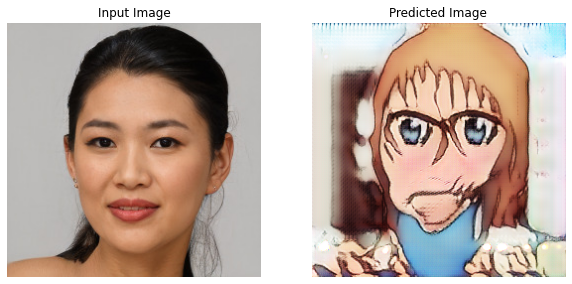

In [28]:
for test_image_path in real_test_paths:
  gen_test_image(test_image_path)

## Key Observations

The GAN model with ResNet in the generator shows improvement in generating anime images where the facial features such as eyes and mouth are in correct position. However the quality of anime portrait generated is still lacking. We will further explore adjusting the model architecture in the next notebook "CycleGAN Female Portrait ResNet ReflectionPadding2D".